<h1>Denoising Autoencoders<br /><small>Jonah Williams</small></h1>

Given data X, an autoencoder tries to learning an efficient coding y that exploits the statistical regularities present in the training examples.  To do so, we construct a a multilayer perceptron where the output layer is the same dimension as the input layer and measure the loss with respect to the original datum.

\begin{align}
y &= \sigma(x W + b) \\
z &= \sigma(y W' + b')
\end{align}
Note that we constrain the weight matrix $W'$ to be the transpose of $W$. If the output is continuous we could use squared loss, or for probabilities the cross entropy loss.
\begin{align}
L(x, \ z \ | \ W, \ b, \ b') &= | \ x - z \ |^2\\
\\
L(x, \ z \ | \ W, \ b, \, b') &= \sum_{k=1}^d x_k log(z_k)
\end{align}



In [1]:
import theano
import theano.tensor as T
import numpy as np
import cPickle
import gzip
import urllib
import matplotlib.pyplot as plt
%matplotlib inline

dataset = "mnist.pkl.gz"
origin = ('http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz')
print 'Downloading data from %s' % origin
urllib.urlretrieve(origin, dataset)


f = gzip.open(dataset, 'rb')
train_set, valid_set, test_set = cPickle.load(f)
f.close()

In [2]:
train_set_x = theano.shared(np.asarray(train_set[0], dtype=theano.config.floatX), borrow=True)
valid_set_x = theano.shared(np.asarray(valid_set[0], dtype=theano.config.floatX), borrow=True)
test_set_x = theano.shared(np.asarray(test_set[0], dtype=theano.config.floatX), borrow=True)

train_set_y = T.cast(theano.shared(np.asarray(train_set[1], dtype=theano.config.floatX), borrow=True), 'int32')
valid_set_y = T.cast(theano.shared(np.asarray(valid_set[1], dtype=theano.config.floatX), borrow=True), 'int32')
test_set_y = T.cast(theano.shared(np.asarray(test_set[1], dtype=theano.config.floatX), borrow=True), 'int32')

In [3]:
class Autoencoder(object):
    
    def __init__(self, n_visible, n_hidden, input=None, W=None, b=None, b_prime=None):
        
        if not W:
            initial_W = np.asarray(
                np.random.uniform(
                    low=-4 * np.sqrt(6. / (n_visible + n_hidden)),
                    high=4 * np.sqrt(6. / (n_visible + n_hidden)),
                    size=(n_visible, n_hidden)
                ), dtype=theano.config.floatX)
            W = theano.shared(value=initial_W, name='W', borrow=True)
        if not b:
            b = theano.shared(
                value=np.zeros(n_visible, dtype=theano.config.floatX),
                name='b', borrow=True)
        if not b_prime:
            b_prime = theano.shared(
                value=np.zeros(n_hidden, dtype=theano.config.floatX),
                name='b_prime', borrow=True)
            
        self.W = W
        self.W_prime = self.W.T
        self.b = b
        self.b_prime = b_prime
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.x = input
            
        self.params = [self.W, self.b, self.b_prime]
        
    def hidden_values(self, input):
        return T.nnet.sigmoid(T.dot(input, self.W) + self.b_prime)
    
    def output_values(self, hidden):
        return T.nnet.sigmoid(T.dot(hidden, self.W_prime) + self.b)
    
    def cost_update(self, learning_rate=0.01):
        y = self.hidden_values(self.x)
        z = self.output_values(y)
        
        L = - T.sum(self.x * T.log(z) + (1 - self.x) * T.log(1 - z), axis=1)
        cost = T.mean(L)
        
        gparams = T.grad(cost, self.params)
        updates = [
            (param, param - learning_rate * gparam)
            for param, gparam in zip(self.params, gparams)]

        return (cost, updates)  

In [4]:
index = T.lscalar()
x = T.matrix('x')
batch_size = 10
    
auto = Autoencoder(n_visible=784, n_hidden=100, input=x)
cost, updates = auto.cost_update(learning_rate=0.1)

train = theano.function([index], cost, updates=updates,
        givens={x: train_set_x[index * batch_size: (index + 1) * batch_size]})
valid = theano.function([], cost,
        givens={x: valid_set_x})
test = theano.function([], cost,
        givens={x: test_set_x})

In [5]:
batches = 5000
epochs = 10
current = 0
validation_loss = []
training_loss = []
while current < epochs:
    for i in xrange(batches):
        training_loss.append(train(i))
    valid_loss = valid()
    print valid_loss
    validation_loss.append(valid_loss)
    current += 1
    print str(current) + "/" + str(epochs)

78.8236834471
1/10
75.767714087
2/10
74.5924364958
3/10
73.8310890607
4/10
73.252832653
5/10
72.6803314092
6/10
72.2606937393
7/10
71.9471069895
8/10
71.6343646648
9/10
71.4528310744
10/10


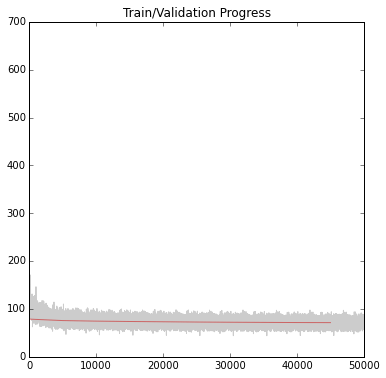

In [6]:
plt.figure(figsize=(6, 6))
plt.plot([i * batches for i in xrange(epochs)], validation_loss, alpha=0.5, color="red")
plt.plot([i for i in xrange(epochs * batches)], training_loss, alpha=0.2, color="black", linewidth=1)
plt.title("Train/Validation Progress")
plt.show()

In [7]:
test()

array(70.98660359165144)

<h2>Resulting Filters</h2>
How can we visualize how our autoencoder works? the answer to this question is the same as "what input maximally activates each neuron?"  If we constrain our input such that the $\sum_i x_i^2 = 1$, it can be shown that our solution is

$$x_j = \frac{W_{i,j}}{\sqrt{\sum_i W_{i,j}^2}}$$

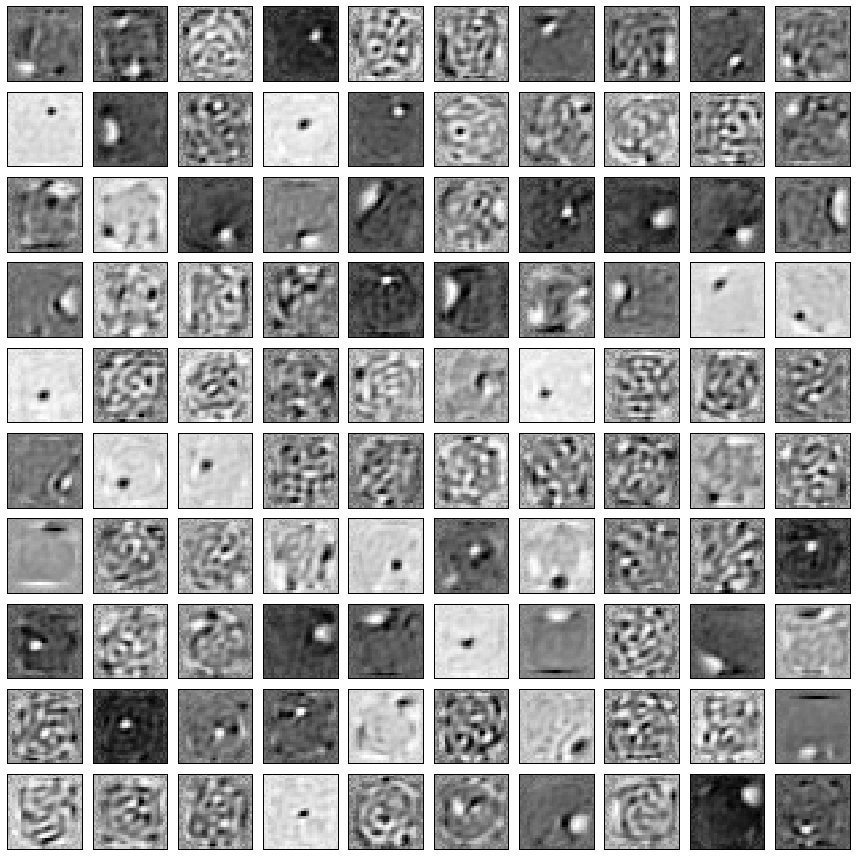

In [8]:
weights = auto.W.get_value()
y = weights / np.sqrt(np.sum(weights**2, axis=0))
fig, ax = plt.subplots(10, 10)
fig.set_size_inches(12, 12)
fig.gca().xaxis.set_major_locator(plt.NullLocator())
fig.gca().yaxis.set_major_locator(plt.NullLocator())

for i in xrange(10):
    for j in xrange(10):
        ax[i, j].imshow(y[:,(i * 10) + j].reshape(28, 28), interpolation="nearest", cmap="Greys")
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
plt.tight_layout()
plt.show()

<h3>Adding Stochastic Noise</h3>
One method of improving the ability of autoencoders to generalize is to add noise to the input data, often in the form of setting some random elements to zero.  We can build this feature into our autoencoder class by modifying the cost_updates function

In [9]:
from theano.tensor.shared_randomstreams import RandomStreams

class Autoencoder(object):
    
    def __init__(self, n_visible, n_hidden, input=None, W=None, b=None,
                 b_prime=None, np_rng=None, theano_rng=None):
        
        if not np_rng:
            np_rng = np.random.RandomState(12345)
        if not theano_rng:
            theano_rng = RandomStreams(np_rng.randint(12312312))

        if not W:
            initial_W = np.asarray(
                np_rng.uniform(
                    low=-4 * np.sqrt(6. / (n_visible + n_hidden)),
                    high=4 * np.sqrt(6. / (n_visible + n_hidden)),
                    size=(n_visible, n_hidden)
                ), dtype=theano.config.floatX)
            W = theano.shared(value=initial_W, name='W', borrow=True)
        if not b:
            b = theano.shared(
                value=np.zeros(n_visible, dtype=theano.config.floatX),
                name='b', borrow=True)
        if not b_prime:
            b_prime = theano.shared(
                value=np.zeros(n_hidden, dtype=theano.config.floatX),
                name='b_prime', borrow=True)
            
        self.W = W
        self.W_prime = self.W.T
        self.b = b
        self.b_prime = b_prime
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.x = input
        self.np_rng = np_rng
        self.theano_rng = theano_rng
            
        self.params = [self.W, self.b, self.b_prime]
        
    def hidden_values(self, input):
        return T.nnet.sigmoid(T.dot(input, self.W) + self.b_prime)
    
    def output_values(self, hidden):
        return T.nnet.sigmoid(T.dot(hidden, self.W_prime) + self.b)
    
    def mask_input(self, input, noise_level):
        return self.theano_rng.binomial(size=input.shape, n=1,
                                        p=1 - noise_level,
                                        dtype=theano.config.floatX) * input
    
    def cost_update(self, noise_level=0, learning_rate=0.01):
        noisy_x = self.mask_input(self.x, noise_level)
        y = self.hidden_values(noisy_x)
        z = self.output_values(y)
        
        L = - T.sum(self.x * T.log(z) + (1 - self.x) * T.log(1 - z), axis=1)
        cost = T.mean(L)
        
        gparams = T.grad(cost, self.params)
        updates = [
            (param, param - learning_rate * gparam)
            for param, gparam in zip(self.params, gparams)]

        return (cost, updates)

In [10]:
auto = Autoencoder(n_visible=784, n_hidden=100, input=x)
cost, updates = auto.cost_update(learning_rate=0.1, noise_level=0.3)

train = theano.function([index], cost, updates=updates,
        givens={x: train_set_x[index * batch_size: (index + 1) * batch_size]})
valid = theano.function([], cost,
        givens={x: valid_set_x})
test = theano.function([], cost,
        givens={x: test_set_x})

In [11]:
batches = 5000
epochs = 10
current = 0
validation_loss = []
training_loss = []
while current < epochs:
    for i in xrange(batches):
        training_loss.append(train(i))
    valid_loss = valid()
    print valid_loss
    validation_loss.append(valid_loss)
    current += 1
    print str(current) + "/" + str(epochs)

86.8540182166
1/10
83.340646344
2/10
81.3631954845
3/10
80.2726893313
4/10
79.3666038349
5/10
79.0721375739
6/10
78.6471149736
7/10
78.346952394
8/10
77.9047254479
9/10
77.7152999366
10/10


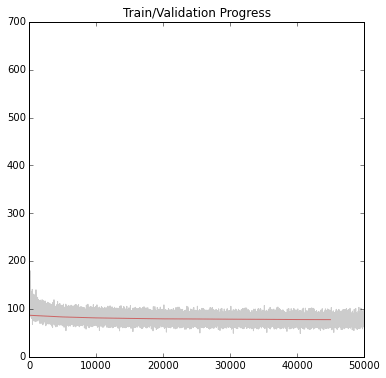

In [12]:
plt.figure(figsize=(6, 6))
plt.plot([i * batches for i in xrange(epochs)], validation_loss, alpha=0.5, color="red")
plt.plot([i for i in xrange(epochs * batches)], training_loss, alpha=0.2, color="black", linewidth=1)
plt.title("Train/Validation Progress")
plt.show()

In [13]:
test()

array(77.27382717149054)

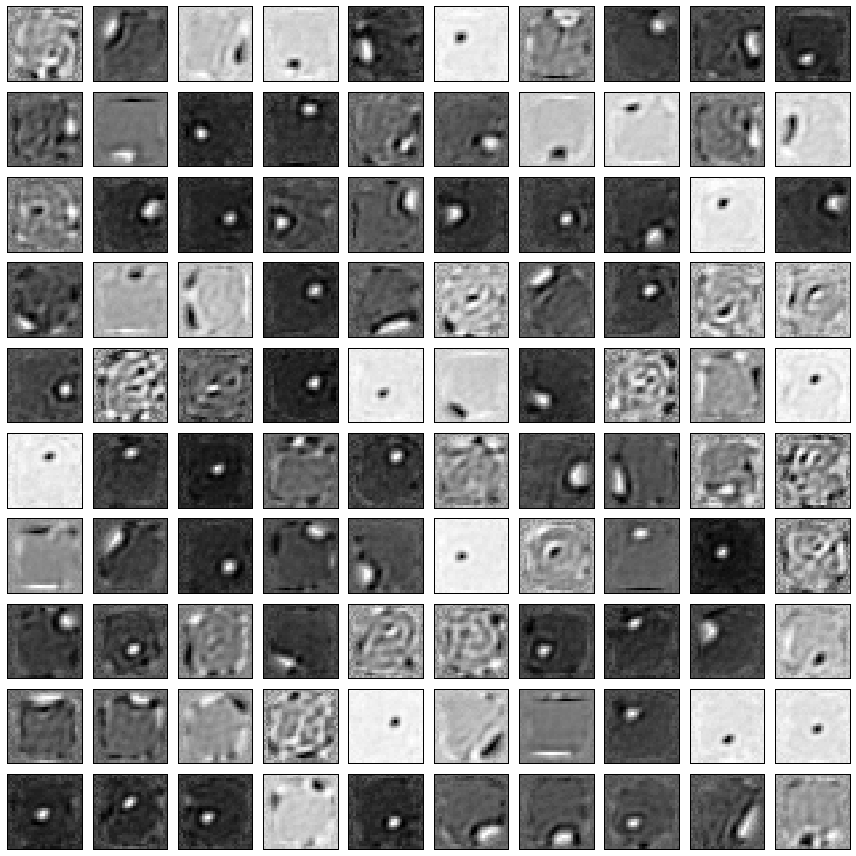

In [14]:
weights = auto.W.get_value()
y = weights / np.sqrt(np.sum(weights**2, axis=0))
fig, ax = plt.subplots(10, 10)
fig.set_size_inches(12, 12)
fig.gca().xaxis.set_major_locator(plt.NullLocator())
fig.gca().yaxis.set_major_locator(plt.NullLocator())

for i in xrange(10):
    for j in xrange(10):
        ax[i, j].imshow(y[:,(i * 10) + j].reshape(28, 28), interpolation="nearest", cmap="Greys")
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
plt.tight_layout()
plt.show()

As we can see above, the filters are a lot smoother!  By introducing noise into our data, we've reduced the noise in our model.

<h3>Stacking Autoencoders</h3>
More hidden layers lets us have more represntational power in our networks.  We can also "stack" autoencoders to get more powerful models.  Relying on unsupervised pretraining helps us find better inital weights, and allows us to take advantage of cases where we have lots of data, but few labels.

In [15]:
import numpy as np
import theano
import theano.tensor as T 
np_rng = np.random.RandomState(1234)

class StackedAutoencoder(object):
    
    def __init__(self, numpy_rng, theano_rng=None,
                 num_in=784, hidden_layers_sizes=[500, 500],
                 num_out=10, noise_levels=[0.1, 0.1]):
        
        self.sigmoid_layers = []
        self.autoencoder_layers = []
        self.params = []
        self.n_layers = len(hidden_layers_sizes)

        assert self.n_layers > 0
        if not theano_rng:
            theano_rng = RandomStreams(numpy_rng.randint(2 ** 30))
        
        self.x = T.matrix('x')
        self.y = T.ivector('y')
        
        for i in xrange(self.n_layers):
            if i == 0:
                input_size = num_in
                layer_input = self.x
            else:
                input_size = hidden_layers_sizes[i - 1]
                layer_input = self.sigmoid_layers[-1].output
                
            
            sigmoid_layer = Layer(input=layer_input,
                                  num_in=input_size,
                                  num_out=hidden_layers_sizes[i])
            self.sigmoid_layers.append(sigmoid_layer)
            self.params.extend(sigmoid_layer.params)
            
            autoencoder_layer = Autoencoder(input=layer_input,
                                           n_visible=input_size,
                                           n_hidden=hidden_layers_sizes[i],
                                           W=sigmoid_layer.W,
                                           b_prime=sigmoid_layer.b)
            self.autoencoder_layers.append(autoencoder_layer)
        
        self.logistic_regression = Layer(input=self.sigmoid_layers[-1].output,
                                        num_in=hidden_layers_sizes[-1],
                                        num_out=num_out,
                                        activation=T.nnet.softmax)
        self.params.extend(self.logistic_regression.params)
        self.finetune_cost = -T.mean(T.log(self.logistic_regression.output)[T.arange(self.y.shape[0]), self.y])
        self.errors = T.mean(T.neq(self.y, T.argmax(self.logistic_regression.output, axis=1))) 
        
    def pretraining_functions(self, train_set_x, batch_size):
        index = T.lscalar('index')
        noise_level = T.dscalar('nl')
        learning_rate = T.dscalar('lr')
        
        batch_start = index * batch_size
        batch_end = batch_start + batch_size
        
        functions = []
        for auto in self.autoencoder_layers:
            cost, updates = auto.cost_update(noise_level, learning_rate)
            
            func = theano.function(
                    inputs=[index,
                            theano.Param(noise_level, default=0.2),
                            theano.Param(learning_rate, default=0.1)
                           ],
                    outputs=cost,
                    updates=updates,
                    givens={
                    self.x: train_set_x[batch_start: batch_end]
                    })
            functions.append(func)

        return functions
    
    def finetuning_functions(self, dataset, batch_size, learning_rate):
        (train_set_x, train_set_y) = dataset[0]
        (valid_set_x, valid_set_y) = dataset[1]
        (test_set_x, test_set_y) = dataset[2]

        n_valid_batches = valid_set_x.get_value(borrow=True).shape[0]
        n_valid_batches /= batch_size
        n_test_batches = test_set_x.get_value(borrow=True).shape[0]
        n_test_batches /= batch_size

        index = T.lscalar('index')

        gparams = T.grad(self.finetune_cost, self.params)

 
        updates = [
            (param, param - gparam * learning_rate)
            for param, gparam in zip(self.params, gparams)
        ]

        train_fn = theano.function(
            inputs=[index],
            outputs=self.finetune_cost,
            updates=updates,
            givens={
                self.x: train_set_x[
                    index * batch_size: (index + 1) * batch_size
                ],
                self.y: train_set_y[
                    index * batch_size: (index + 1) * batch_size
                ]
            },
            name='train'
        )

        test_fn = theano.function(
            [],
            self.errors,
            givens={
                self.x: test_set_x,
                self.y: test_set_y
            },
            name='test'
        )

        valid_fn = theano.function(
            [],
            self.errors,
            givens={
                self.x: valid_set_x,
                self.y: valid_set_y
            },
            name='valid'
        )


        return train_fn, valid_fn, test_fn
        
        

        
class Layer(object):
    def __init__(self, input, num_in, num_out,
                 W=None, b=None, activation=T.nnet.sigmoid):

        if not W:
            W = np.asarray(np_rng.uniform(
                                   low=-np.sqrt(6. / (num_in + num_out)),
                                   high=np.sqrt(6. / (num_in + num_out)),
                                   size=(num_in, num_out)),
                       dtype=theano.config.floatX)
        if not b:
            b = np.zeros((num_out,), dtype=theano.config.floatX)
        
        self.input = input
        self.W = theano.shared(value=W, name='W', borrow=True)
        self.b = theano.shared(value=b, name='b', borrow=True)
        self.output = activation(T.dot(input, self.W) + self.b)
        self.params = [self.W, self.b]
        

In [16]:
rng = np.random.RandomState(1234)
Neuromancer = StackedAutoencoder(rng,
                                num_in=28 * 28,
                                hidden_layers_sizes=[500, 250, 100],
                                num_out=10)

In [17]:
dataset = [(train_set_x, train_set_y), (valid_set_x, valid_set_y), (test_set_x, test_set_y)]

In [18]:
pretraining_fns = Neuromancer.pretraining_functions(train_set_x=train_set_x,
                                                batch_size=10)

In [19]:
corruption_levels = [.3, .2, .1]
pretrain_lr = 0.01
n_train_batches = 5000
for i in xrange(Neuromancer.n_layers):
    for epoch in xrange(10):
        c = []
        for batch_index in xrange(n_train_batches):
            c.append(pretraining_fns[i](index=batch_index,
                     nl=corruption_levels[i],
                     lr=pretrain_lr))
        print np.mean(c)

103.863264918
81.8330320996
77.9449644716
75.9479813186
74.5766749534
73.5090473004
72.6678427576
71.9691063477
71.2973704038
70.7142924585
198.610975999
179.971491452
176.77454559
175.25152056
174.272351457
173.542492089
172.932106645
172.393195951
171.947098504
171.557440946
94.5111550401
79.686919519
76.9074225295
75.6361079078
74.8991658811
74.4032701623
74.0508441542
73.7675818671
73.5413973786
73.3578763306


In [20]:
train, valid, test = Neuromancer.finetuning_functions(dataset, batch_size=10, learning_rate=0.01)

In [21]:
n_train_batches = 5000
for epoch in xrange(20):
    for batch_index in xrange(n_train_batches):
        train(batch_index)
    print valid()

0.0848
0.0713
0.0645
0.0598
0.0562
0.0519
0.0478
0.0463
0.0449
0.0433
0.0423
0.0411
0.04
0.0389
0.0384
0.0378
0.0375
0.0366
0.0361
0.0359


In [22]:
test()

array(0.0395)

WELL SHIAT

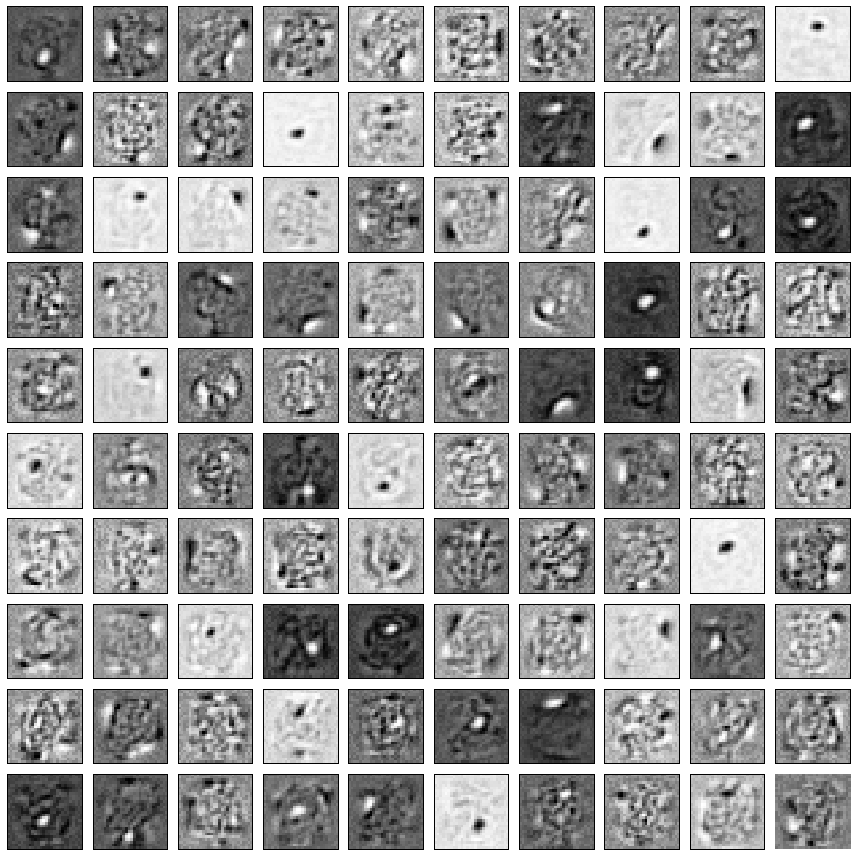

In [42]:
weights = Neuromancer.params[0].get_value()
y = weights / np.sqrt(np.sum(weights**2, axis=0))
fig, ax = plt.subplots(10, 10)

fig.set_size_inches(12, 12)
fig.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.margins(0,0)


fig.gca().xaxis.set_major_locator(plt.NullLocator())
fig.gca().yaxis.set_major_locator(plt.NullLocator())

for i in xrange(10):
    for j in xrange(10):
        ax[i, j].imshow(y[:,(i * 10) + j].reshape(28, 28), interpolation="nearest", cmap="Greys")
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
plt.tight_layout()
plt.savefig('1.png', bbox_inches="tight")
plt.show()